# 004: Grain Mapping
### Map grains by identifying cluster of pixels in orientation space

Method inspired from Johnstone et al. (2020) (https://arxiv.org/abs/2001.02716), using density-based clustering (DBSCAN). The distance metrics combines symmetry-reduced orientations and ($x$,$y$) position of pixels in the sample, to take into account both position and orientation of pixels. 

This notebook has been written to process a stack of 2D slices and map grains in 3D, but it work as well to process just one slice.
***
WARNING: This is a very rough approach, which works as long as the orientation clusters formed by the different grains are well separated. There is no guarantee that groups of pixels identified this way correspond to topologically valid grains: a single cluster can correspond to disconnected groups of pixels / voxels. For more robust grain mapping, there are several methods implemented in MTex which rely on identification of grain boundaries. 
***

In [ ]:
### load packages

In [1]:
# general modules
import os, sys
import numpy as np
import pylab as pl
from tqdm import tqdm

# ImageD11 + point-fit 3dxrd module
import ImageD11.grain
import ImageD11.columnfile

if '/home/esrf/jean1994b/' not in sys.path:
    sys.path.append('/home/esrf/jean1994b/')
from pf_3dxrd import utils, pixelmap, friedel_pairs, crystal_structure, peak_mapping

# orix
from orix import quaternion as oq, vector as ovec


# clustering
from sklearn.cluster import DBSCAN

# color and plotting
from skimage.color import label2rgb
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.colors import to_rgb
import matplotlib.animation as animation

%matplotlib ipympl
%load_ext autoreload
%autoreload 2

### Load data  

In [2]:
def load_data(dset, load_cf=False, detector='eiger'):
    xmap_file = os.path.join(data_dir, dset+'_xmap.h5')
    peakfile = os.path.join(data_dir, dset+'_pks_p_flt.h5')

    xmap = pixelmap.load_from_hdf5(xmap_file)
    print(xmap)
    
    if not load_cf:
        return xmap
    
    else:
        cf = ImageD11.columnfile.columnfile(peakfile)
        cf.parameters.loadparameters(parfile)
        cf.updateGeometry()
        friedel_pairs.update_geometry_s3dxrd(cf, detector=detector, update_gvecs=True)
        cf.sortby('xyi')
        
        return xmap, cf 

In [3]:
# paths
data_dir = 'data'
parfile='data/SI3.par'
sample = 'SI3'

# list of datasets to load. If there is just one, put it in a list with one single element 
dslist = ['SI3_DT360Z5480'] 

# list of phases to process. If there is just one, put it in a list with one single element
phase_name_list = ['quartz', 'magnetite']  


Create a dictionnary containing all 2D maps, and build features space for clustering.

In [4]:
%%time
# dictionnary keys
###################
# dset: dataset name
# xmap: pixelmap
# features_[phasename]: normalized 4D space to perform clustering
# mask_[phasename]: mask to select pixels corresponding to the given phase on the map. 

keys = ['dset', 'xmap'] + [f'features_{p}' for p in phase_name_list] +\
                          [f'mask_{p}' for p in phase_name_list]     +\
                          [f'ori_{p}' for p in phase_name_list]

data = [[] for _ in range(len(keys))]
xmap_dict = dict(zip(keys,data))        
    
# load xmaps

for dsname in dslist:
    xmap = load_data(dsname)
    xmap.add_data(np.full(xmap.xyi.shape, -1, dtype=np.int16), 'grain_id')
    xmap_dict['dset'].append(dsname)
    xmap_dict['xmap'].append(xmap)

    
    

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 41
CPU times: user 571 ms, sys: 1.19 s, total: 1.76 s
Wall time: 440 ms


Build normalized space of features and return the coordinates of each pixels in this space.

In [29]:
def get_normalized_feature_space(xmap, pname):
    """ select orientation from xmap and return normalized feature space built using symetry-reduced orientations 
    (in euler angles) and (x,y) position: (eul1, eul2, xi, yi). Each dimension is rescaled to values between 0 and 1
    
    return:
    features: 4D array of values to perform clustering
    cs: corresponding crystal phase
    mask : phase mask for pixels in xmap
    """
    # phase structure, mask and symmetry
    cs = xmap.phases.get(pname)
    msk = xmap.phase_id == cs.phase_id
    sym = cs.orix_phase.point_group.laue
    # orientation in symmetry reduced zone
    ori_quat = oq.Orientation.from_matrix(xmap.U[msk], symmetry = sym)
    ori_quat = ori_quat.map_into_symmetry_reduced_zone()
    ori_euler = ori_quat.to_euler(degrees=True)
    xi, yi = xmap.xi[msk], xmap.yi[msk]
    
    # normalize
    d1 = ori_euler[:,0] / 360
    d2 = ori_euler[:,1] / 90
    d3 = (xi - xi.min()) / (xi.max() - xi.min())
    d4 = (yi - yi.min()) / (yi.max() - yi.min())
    
    return ori_quat, np.array([d1,d2,d3,d4]).T, cs, msk

def update_dict(pname):
    # compute feature space for each map and update dictionnary
    for xmap in xmap_dict['xmap']:
        ori, features, cs, msk = get_normalized_feature_space(xmap, pname)
        xmap_dict[f'mask_{pname}'].append(msk)
        xmap_dict[f'features_{pname}'].append(features)
        xmap_dict[f'ori_{pname}'].append(ori)


for pname in phase_name_list:
    update_dict(pname)

# print updated dictionnary to check it is ok
# xmap size and mask_phase should have the same shape
# feature_phase shape should be (N,4) with N <= xmap size

for i, dset in enumerate(xmap_dict['dset']):
    print(f'Dataset {dset}\n-----------------------')
    for k,v in xmap_dict.items():
        if 'xmap' in k:
            print(f'{k} size: {v[i].xyi.shape}')
        if any(['features' in k, 'mask' in k]):
            print(f'{k}:{v[i].shape}')
            
    print('=========================')
        
        

Dataset SI3_DT360Z5480
-----------------------
xmap size: (12100,)
features_quartz:(1538, 4)
features_magnetite:(94, 4)
mask_quartz:(12100,)
mask_magnetite:(12100,)


Concatenate all arrays of feature into one big array for each phase. This will allow to do clustering in 3D instead of doing it slice by slice (ie. directly identify grains in 3D)

In [30]:
stacked_features = {pname:_ for pname in phase_name_list}

for pname in phase_name_list:
    stacked_features[pname] = np.concatenate([ft for ft in xmap_dict[f'features_{pname}']])
    print(f'All datasets - {pname}: {stacked_features[pname].shape}')

All datasets - quartz: (1538, 4)
All datasets - magnetite: (94, 4)


### DBSCAN Clustering

In [35]:
# function to perform clustering and cost function

def fit_dbscan(data, eps, min_samples):
    # define the models
    model = DBSCAN(eps=eps, min_samples=min_samples)

    # fit models and predict clusters
    labels = model.fit_predict(data)

    # retrieve unique clusters
    clusters = np.unique(labels)
    
    # calculate value of cost_function
    cost = cost_function(data, labels, clusters)
    
    return clusters, labels, cost


def cost_function(data, labels, clusters):
    # cost is defined by the sum of distances between data points and cluster centroids for all clusters
    
    # initialize
    cost = 0
    
    # loop through clusters
    for clst in clusters:
        # select data from cluster
        data_subset = data[labels == clst]
        # cluster centroid position
        cluster_cen = np.median(data_subset, axis=0)
        # sum of distance between data in cluster and centroid
        dist_tot = np.sum(np.linalg.norm(data_subset - cluster_cen, axis=1))
        cost += dist_tot
    
    # normalize cost to number of data points
    cost = cost / len(labels) 
    return cost


DBSCAN has two parameters to tune: eps and min_sample. Try different values to find where the cost function reaches a minimum. If there are multiple phases, this has to be done independently for each phase.

100%|██████████| 100/100 [00:00<00:00, 680.45it/s]


Text(0, 0.5, 'N clusters')

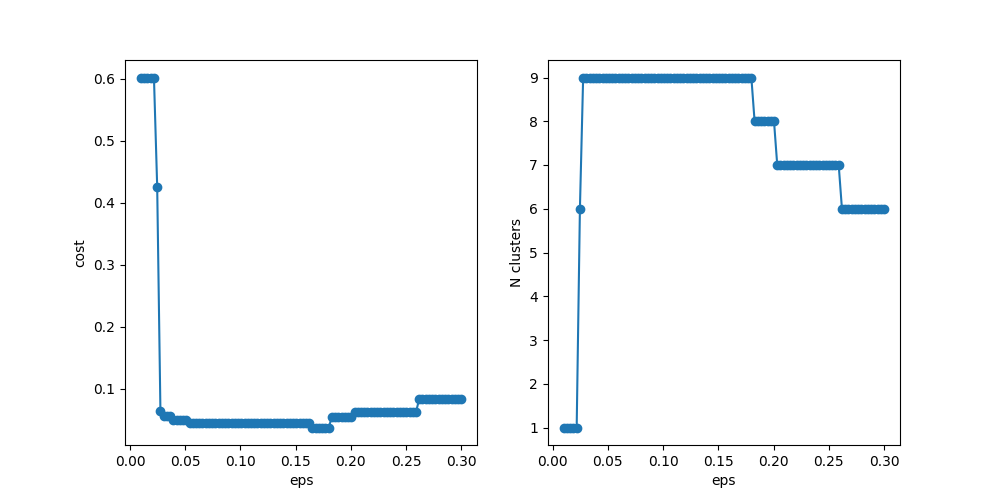

In [36]:
# vary eps
eps = np.linspace(0.01,0.3,100)
min_samples = 4
costs = []
nclusters = []

for e in tqdm(eps):
    clst, labs, cost = fit_dbscan(stacked_features['magnetite'], e, min_samples)
    costs.append(cost)
    nclusters.append(len(clst))

fig = pl.figure(figsize=(10,5))
fig.add_subplot(121)
pl.plot(eps, costs,'o-')
pl.xlabel('eps')
pl.ylabel('cost')

fig.add_subplot(122)
pl.plot(eps,nclusters,'o-')
pl.xlabel('eps')
pl.ylabel('N clusters')

100%|██████████| 20/20 [00:00<00:00, 79.53it/s]


Text(0, 0.5, 'N clusters')

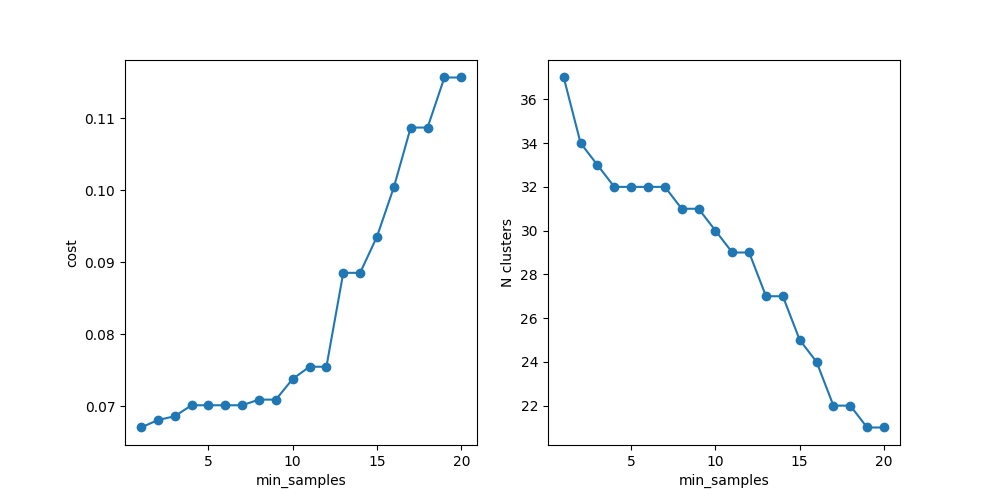

In [37]:
# vary min_samples
eps = 0.17
min_samples = np.arange(1,21)
costs = []
nclusters = []

for ms in tqdm(min_samples):
    clst, labs, cost = fit_dbscan(stacked_features['quartz'], eps, ms)
    costs.append(cost)
    nclusters.append(len(clst))

fig = pl.figure(figsize=(10,5))
fig.add_subplot(121)
pl.plot(min_samples, costs,'o-')
pl.xlabel('min_samples')
pl.ylabel('cost')

fig.add_subplot(122)
pl.plot(min_samples,nclusters,'o-')
pl.xlabel('min_samples')
pl.ylabel('N clusters')

Once optimal clustering parameters have been found, perform DBSCAN clustering. 

In [38]:
# clustering params for each phase in stacked_features
eps_list = [0.06, 0.17]
min_samples_list = [10,5]

# initialize dict of results
grain_labels = {p:[] for p in stacked_features}

# Clustering: return a grain label for each data point 
for p,eps,ms in zip(stacked_features, eps_list, min_samples_list):
    clst, labs, cost = fit_dbscan(stacked_features[p], eps, ms)
    grain_labels[p] = labs
    print(f'{p} pixels clustering completed. Found {len(clst)-1} unique grains.')
    
    
# We do not want grains from different phases to have the same grain label. Thus we need to update the results so that each phase has its 
# unique set of grain labels
print('===================================')
print('unique grain labels\n----------------------------')
for i, (p, labs) in enumerate(grain_labels.items()):
    
    # for the first phase in grain labels dict, do not change anything
    if i == 0:
        labels_unique = np.unique(labs)
    # for other phases, update labels whenever they are > -1 (-1 stands for non-labeled outliers)
    else:
        labs = np.where(labs == -1, -1, labs + max(labels_unique) + 1)
        labels_unique = np.concatenate((labels_unique,np.unique(labs)))
        grain_labels[p] = labs
        
    # print outputs
    print(f'{pname}:\n{np.unique(labs)}\n-----------------------')
    

quartz pixels clustering completed. Found 34 unique grains.
magnetite pixels clustering completed. Found 7 unique grains.
unique grain labels
----------------------------
magnetite:
[-1  0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22
 23 24 25 26 27 28 29 30 31 32 33]
-----------------------
magnetite:
[-1 34 35 36 37 38 39 40]
-----------------------


### Plots
Plot clusters in symmetry-reduced orientation space

In [39]:
# define colormap for clusters
Ncolors = labels_unique.max() + 1
cmap = utils.random_color_map(Ncolors)

In [40]:
# plotting functons

def get_stacked_orientations(pname, cs):
    """ return all orientations for the data stack, mapped into the symmetry_reduced zone"""
    # select data
    ori_arr = np.concatenate([o.data for o in xmap_dict[f'ori_{pname}']])  # stacked orientations from all maps
    ori_stacked = oq.Orientation(ori_arr, symmetry=cs.orix_phase.point_group.laue)
    ori_stacked.map_into_symmetry_reduced_zone()
    
    return ori_stacked


def get_cluster_orientations(ori, labels, cs):
    """ 
    return cluster labels, size, and mean orientation mapped into the symmetry-reduced zone
    ori : pixel orientations
    labels: cluster label for each pixel. should have same length as ori
    """
    cluster_ids, cluster_sizes = np.unique(labels, return_counts=True)

    # mean cluster orientation
    q_mean = [ori[labels == l].mean() for l in  cluster_ids[1:]]
    ori_clusters = oq.Orientation.stack(q_mean).flatten()
    ori_clusters.symmetry = ori.symmetry
    ori_clusters.map_into_symmetry_reduced_zone()
    
    return cluster_ids, cluster_sizes, ori_clusters
    


def plot_ipf_orientations(pname, cluster_size_factor = 10, ipf_direction = [0,0,1], save=False):
    """ 
    plot pixel orientation in inverse pole figure space
    pname : phase name 
    cluster_size_factor: adjust spot size for clusters in scatter plot
    ipf_direction: reference direction ofr the inverse pole figure. z-axis = [0,0,1] (default)
    save (bool): save plot
    """
    labels = grain_labels[pname]
    # pixel orientations
    cs = xmap_dict['xmap'][0].phases.get(pname)
    ori = get_stacked_orientations(pname, cs)
    
    # cluster average orientations
    cluster_ids, cluster_sizes, ori_clusters = get_cluster_orientations(ori, labels, cs)
    cluster_size_scaled =  cluster_size_factor * cluster_sizes / cluster_sizes.max()  # rescale cluster size (for plotting)
    
    # IPF reference orientation + arguments for plotting
    oref = ovec.Vector3d(ipf_direction)
    kw_subplot = {'projection':'ipf', 'symmetry':cs.orix_phase.point_group.laue, 'direction':oref}
    kw_density = {'cmap':'Reds', 'log':True, 'resolution':.5, 'sigma':.5}

    fig = pl.figure(figsize=(10,5))
    ax1 = fig.add_subplot(121, **kw_subplot)
    ax2 = fig.add_subplot(122, **kw_subplot)

    ax1.scatter(ori, s=2., c = labels, cmap = cmap, vmin=-1, alpha=.3)  # all data point colored by labels
    ax1.scatter(ori_clusters, s = cluster_size_scaled[1:],
                c = cluster_ids[1:], cmap = cmap, vmin=-1, lw=0., alpha=.3)       # orientation clusters
    ax2.pole_density_function(ori * oref, **kw_density)

    fig.suptitle(f'{pname} clusters')

    if save:
        fig.savefig(os.path.join(data_dir, f'{sample}_ipf_clusters_{pname}.png'), format='png')
 


        
def plot_in_fundamental_zone(ori, labels, pname, **kw):

    # Top view of the recentered orientation clusters within the fundamental zone. 

    wireframe_kwargs = dict(color="black", linewidth=0.5, alpha=0.1, rcount=181, ccount=361)
    
    fig = ori.scatter(projection="axangle", wireframe_kwargs=wireframe_kwargs, c=labels, **kw,
                      return_figure=True)
    ax = fig.axes[0]
    ax.view_init(elev=90, azim=-30)

    handle_kwds = dict(marker="o", color="none", markersize=30)
    handles = []

    ax.legend(
        handles=handles,
        loc="lower right",
        ncol=2,
        numpoints=1,
        labelspacing=0.15,
        columnspacing=0.15,
        handletextpad=0.05,
    );
    
    return fig


def animate(angle):
    fig.axes[0].view_init(15, angle)
    pl.draw()


/home/esrf/jean1994b/3dxrd_env/lib/python3.8/site-packages/orix/measure/pole_density_function.py:223: RuntimeWarning: divide by zero encountered in log
  hist = np.log(hist + 1)


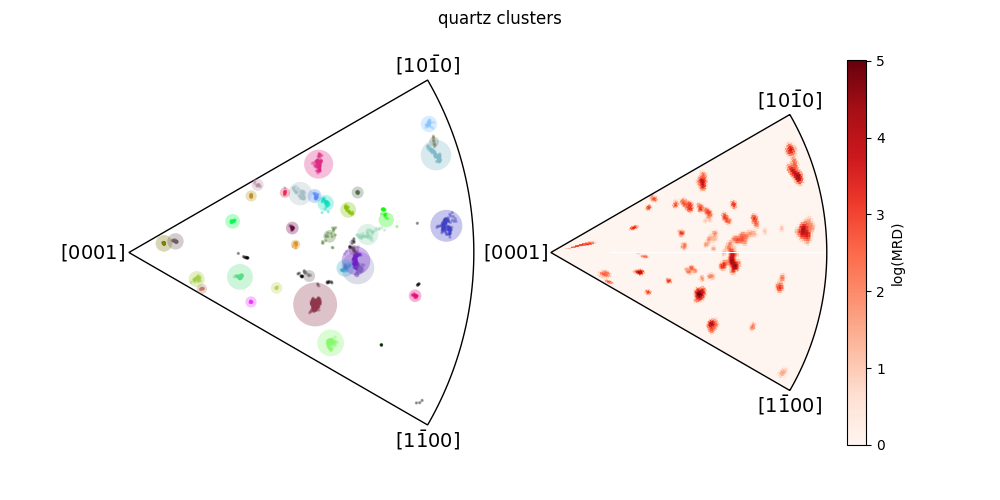

In [42]:
#plots in inverse pole figure space
plot_ipf_orientations('quartz', ipf_direction=[1,0,0], cluster_size_factor=1000, save=False)

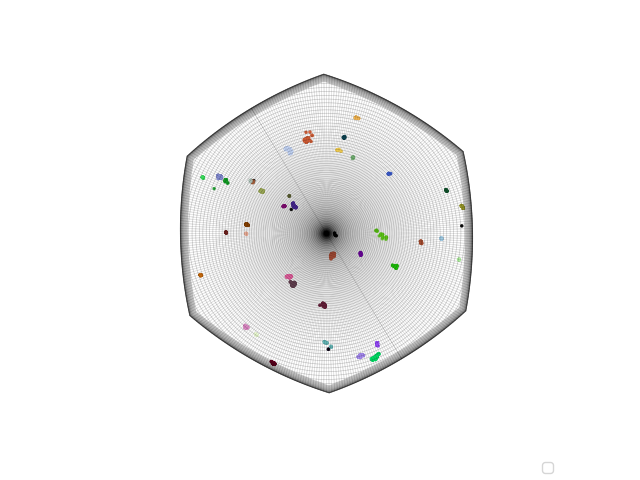

In [20]:
# plot orientation in fundamental zone
pname = 'quartz'


labels = grain_labels[pname]
cs = xmap_dict['xmap'][0].phases.get(pname)
ori = get_stacked_orientations(pname, cs)
cluster_ids, cluster_sizes, ori_clusters = get_cluster_orientations(ori, labels, cs)

# all pixels
kw = {'cmap':cmap, 'vmin':-1, 's':2}
fig = plot_in_fundamental_zone(ori, labels, pname, **kw)

# mean cluster orientation
#kw = {'cmap':cmap, 'vmin':-1, 's':cluster_sizes[1:]}
#fig = plot_in_fundamental_zone(ori_clusters, cluster_ids[1:], pname, **kw)

# animate
ani = animation.FuncAnimation( fig, animate, np.linspace(75, 360 + 74, 720), interval=25)

### Add grain labels to xmaps
extract labels stored in grain_labels dict and update grain_id columns for all 2D maps in the stack 

In [5]:
def add_grain_labels_to_xmaps(pname):
    
    labels_all = grain_labels[pname]    # all labels in 3D stack     
    
    # index positions to split grain_labels[pname] by 2D slices
    inds = [0]
    for f in xmap_dict[f'features_{pname}']:
        inds.append(inds[-1] + len(f) )
    
    # loop through 2D map stack
    print(f'Adding labels to xmaps for phase {pname}')
    for i, (xmap, msk) in tqdm( enumerate(zip(xmap_dict['xmap'], xmap_dict[f'mask_{pname}'])) ):
        # extract labels corresponding to the 2D slice
        labels_slice2D = labels_all[inds[i]:inds[i+1]]
        assert len(labels_slice2D) == np.count_nonzero(msk), 'labels shape does not match with phase mask' # sanity check
        
        # update grain_id labels in xmap
        xmap.update_pixels(xmap.xyi[msk], 'grain_id', labels_slice2D)
        

In [6]:
for pname in phase_name_list:
    add_grain_labels_to_xmaps(pname)

NameError: name 'grain_labels' is not defined

Plot grain masks in each map to check grain label extraction is ok

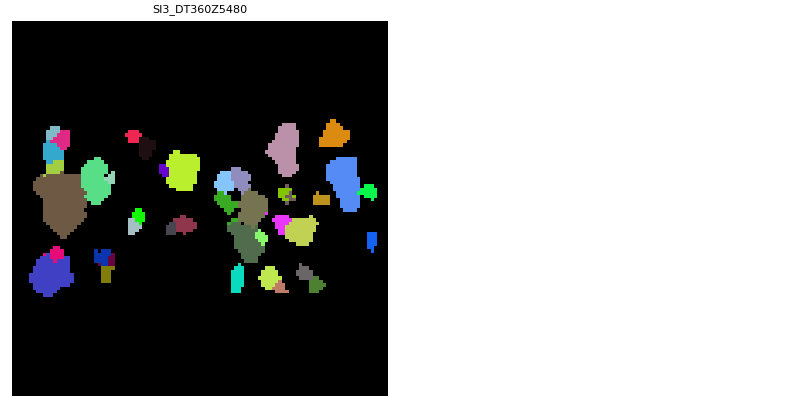

In [45]:
# plot grain maps 
kw = {'cmap':cmap, 'vmin':-1, 'vmax':labels_unique.max()}
ncol = 2
nrow = np.ceil(len(xmap_dict['xmap'])/ncol).astype(int)

# grid
xmap = xmap_dict['xmap'][0]
nx, ny = xmap.grid.nx, xmap.grid.ny
xb, yb = xmap.grid.xbins, xmap.grid.ybins

pl.close('all')
fig, ax = pl.subplots(nrow, ncol, figsize=(4*ncol,4*nrow), layout = 'constrained')
ax = ax.ravel()
for a in ax:
    a.set_axis_off()
    a.set_aspect('equal')

for a,x,d in zip(ax, xmap_dict['xmap'], xmap_dict['dset']):
    a.pcolormesh(xb,yb,x.grain_id.reshape(nx,ny), **kw)
    a.set_title(d, fontsize=8)
    

#fig.savefig(os.path.join(data_dir, f'{sample}_grain_map.png'), format='png')

Define grain from grain masks: compute mean unitcell and orientation over each grain mask and use them to compute an "average" unit cell matrix for the grain. Grains are added to xmap.grains and will be saved in the same file as the pixelmap. 

In [46]:
# add grains to xmap.grains and save maps
for x,d in (zip(xmap_dict['xmap'], xmap_dict['dset'])):
    # loop through all phases
    for i, p in enumerate(phase_name_list):
        if i == 0:
            x.add_grains_from_map(p, overwrite=True)
        else:
            x.add_grains_from_map(p, overwrite=False)
    # save
    x.save_to_hdf5()

100%|██████████| 8/8 [00:00<00:00, 21.73it/s]

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5


### Add grain labels to peakfiles
Now we need to do peaks ot grains / grains to peak mapping, ie associate each peak in the peakfile to a grain and each grain in xmap.grians to a set of peaks in the peakfle. This is done with the function map_grains_to_cf from peak_mapping module. Peaks assigned ot each grain will then be used to refine the unit cell matrix of each grain. 

In [7]:
def check_grain_labels(cf, xmap):
    # check grain labels are consistent in xmap.grain_id, xmap.grains and peakfile
    gids_xmap = np.unique(xmap.grain_id)
    gids_glist = np.unique(np.array(xmap.grains.gids))
    gids_cf = np.unique(cf.grain_id)
    
    assert np.all(np.equal(gids_xmap[1:], gids_glist)), 'grain labels in xmap.grain_id and xmap.grains do not match'
    assert np.all(np.equal(gids_xmap, gids_cf)), 'grain labels in xmap and peakfile do not match'
    
    print('grain labels OK')

In [8]:
# store reloaded maps + peakfiles in new dict
data_dict = {k:[] for k in ['dset', 'xmap', 'cf']}


for dsname in dslist:
    # load data
    xmap, cf = load_data(dsname, load_cf=True, detector = 'frelon')
    
    # peaks to grains mapping 
    peak_mapping.map_grains_to_cf(xmap.grains.glist, cf, overwrite=True)
    
    # sanity check
    check_grain_labels(cf, xmap)
    
    # add to dict
    data_dict['dset'].append(dsname)
    data_dict['xmap'].append(xmap)
    data_dict['cf'].append(cf)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz', 'magnetite', 'biotite', 'orthoclase', 'oligoclase'],
 phase_ids: [-1, 0, 1, 2, 3, 4],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 41
Reading your columnfile in hdf format


100%|██████████| 41/41 [00:00<00:00, 920.49it/s]

completed
grain labels OK


### Refine mean grain unitcell matrices
Average unit cell matrices (UBI) have been computed for each grain by averaging unitcell and orientation over each grain mask. However, this approach is not very robust: all pixels have the same weight, regardless of the number of peaks indexed and indexing quality. To refine these orientations, we do a refinement of the UBI matrix using the whole set of peaks mapped to each grain. 

In [9]:
def refine_ubis(xmap, cf, pname, hkltol, nmedian, plot_stats=True):
    """
    for each grain, refine ubi using all peaks from cf that have been assigned to this grain
    pname : phase name
    hkltol : hkl tolerance (passed to cImage11.score_and_refine)
    nmedian:  threshold to remove outliers ( abs(median err) > nmedian )
    
    """
    cs = xmap.phases.get(pname)
    pkprop, ang_dev = xmap.refine_ubis( pname, cf, hkltol, nmedian=10, sym = cs.orix_phase.point_group.laue)
    
    if plot_stats:   
        gids = xmap.grains.get_all('gid', pname)
        gs = xmap.grains.get_all('grainsize', pname)
        
        fig = pl.figure(figsize=(5,5))
        fig.add_subplot(111)
        
        pl.scatter(pkprop, ang_dev, c = gids, s = 50 * (gs/max(gs)))
        pl.title(f'refinement stats {pname}')
        pl.xlabel('prop pks retained')
        pl.ylabel('orientation shift (deg)')
    
    return pkprop, ang_dev

refining ubis...


100%|██████████| 34/34 [00:00<00:00, 57.65it/s]


refining ubis...


100%|██████████| 7/7 [00:00<00:00, 173.96it/s]


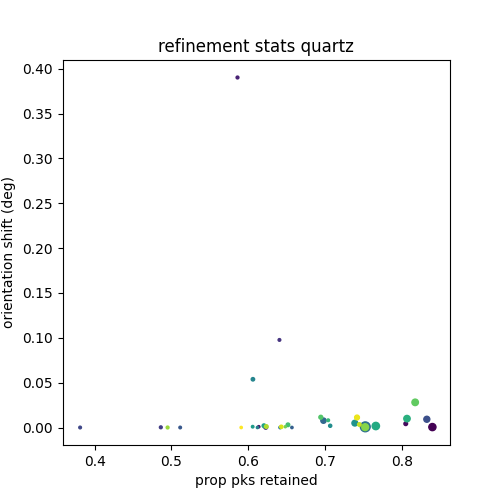

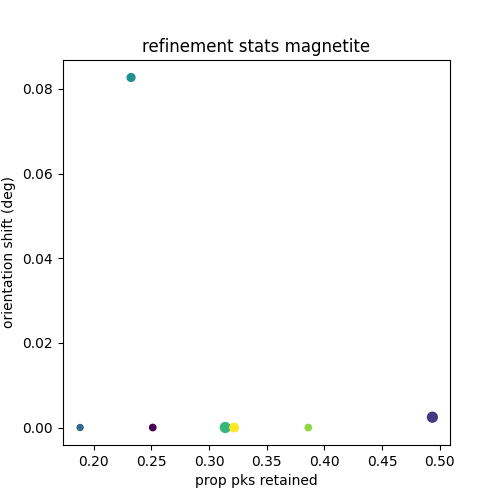

In [10]:
for xmap,cf in zip(data_dict['xmap'], data_dict['cf']):
    for pname in phase_name_list:
        pkprop, ang_dev = refine_ubis(xmap, cf, pname, hkltol=0.2, nmedian=10, plot_stats=True)

In [11]:
# Once grain ubis have been refined, save files
for xmap,cf in zip(data_dict['xmap'], data_dict['cf']):
    pkspath = xmap.h5name.replace('xmap', 'pks_p_flt')
    xmap.save_to_hdf5()
    utils.colf_to_hdf(cf, pkspath, save_mode='minimal')

Pixelmap saved to: data/SI3_DT360Z5480_xmap.h5


***
### Map and plot grain properties

Grain mapping has been completed. Below are a few examples of plots that can be done using average grain properties. 

In [12]:
# select one xmap
xmap = data_dict['xmap'][0]

# filter to keep only quartz grains
xmap2 = xmap.filter_by_phase('quartz')
print(xmap2)

Pixelmap:
 size: (110, 110),
 phases: ['notIndexed', 'quartz'],
 phase_ids: [-1, 0],
 titles: ['xyi', 'xi', 'yi', 'phase_id', 'grain_id', 'Npks', 'U', 'UBI', 'completeness', 'drlv2', 'nindx', 'phase_label_confidence', 'uniqueness', 'unitcell'], 
 grains: 34


In [14]:
Ncolors = len(xmap2.grains.glist)+1
cmap = utils.random_color_map(ncolors=Ncolors)

kw = {'cmap':cmap, 'vmin':-2, 'vmax':Ncolors+1}

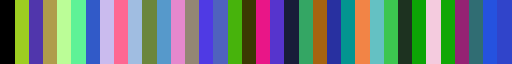

In [15]:
cmap

'data/SI3_DT360Z5480_grainmap_quartz.png'

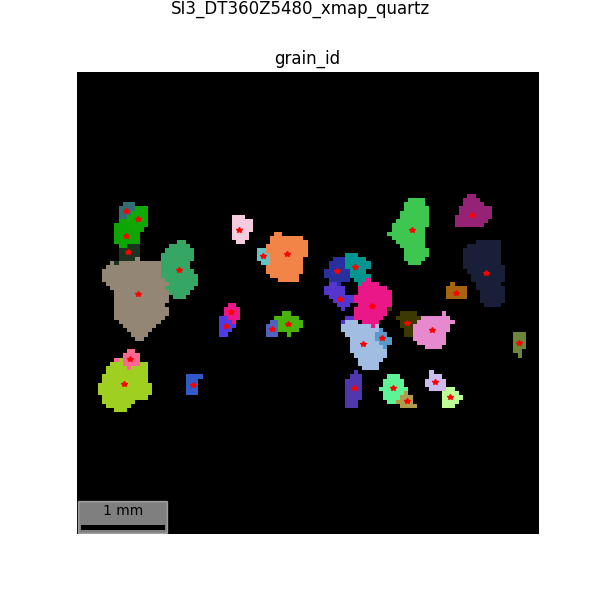

In [16]:
# plot map of grain_id + add position of grain centroids

cen = xmap2.grains.get_all('centroid', 'quartz')
xb, yb = xmap2.grid.xbins, xmap2.grid.ybins
nx ,ny = xmap2.grid.nx, xmap2.grid.ny

fig = xmap2.plot('grain_id', autoscale=False, **kw, out=True, hide_cbar=True)
fig.axes[0].plot(cen[:,0], cen[:,1],'r*', ms=4.)

fname =os.path.join(data_dir,f'{dsname}_grainmap_quartz.png')
fname
#fig.savefig(fname, format='png', dpi=150)

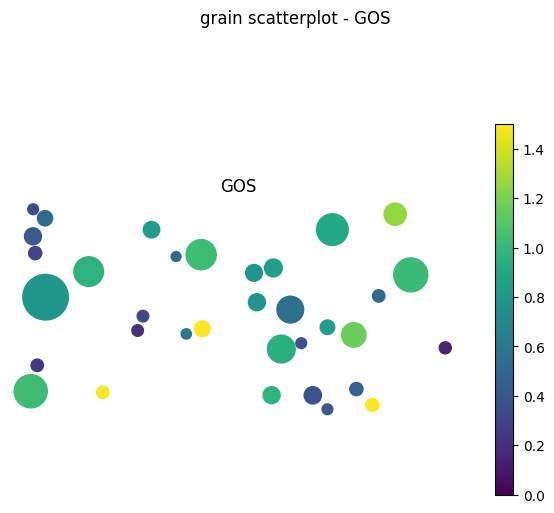

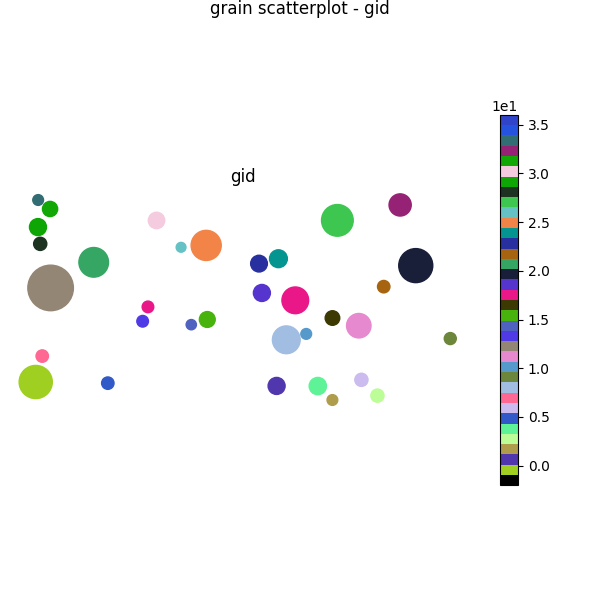

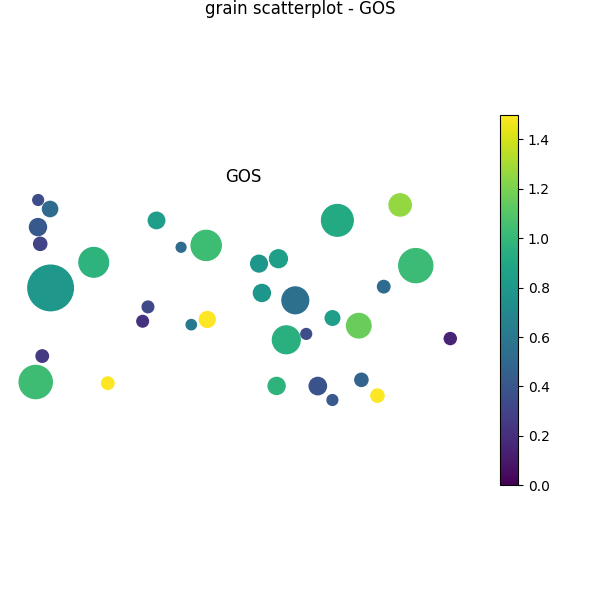

In [20]:
# you can also plot grain prperties in a scatterplot, where circle radius scales with grain size

# grain id
xmap2.grains.plot_grains_prop('gid', s_factor=1/5, out=True, **kw)

# grain orientation spread GOS
kw2 = {'vmin':0, 'vmax':1.5}
xmap2.grains.plot_grains_prop('GOS', s_factor=1/5, autoscale=False, out=True, **kw2)

Another useful feature: you can map grain properties to the 2D pixel grid. e.g below for the grain orientation spread. Average grain properties are added as a new column in pixelmap with an '_g' in the end to distinguish them from original pixel properties

34it [00:00, 54911.95it/s]
34it [00:00, 36185.32it/s]


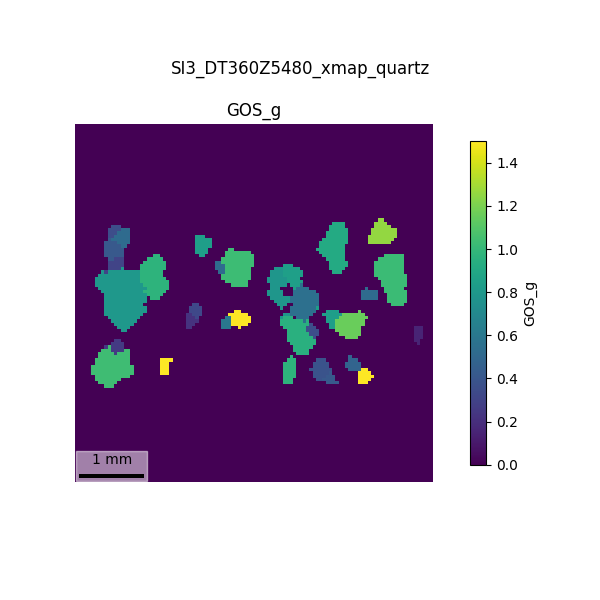

In [24]:
xmap2.map_grain_prop('GOS', pname='quartz')
xmap2.plot('GOS_g', autoscale=False, **kw2)

If you do it with orientation matrix U, it will also compute pixel misorientation (ie deviation from average grain orientation in degree for each pixel assigned to a grain mask)

34it [00:00, 1091.10it/s]


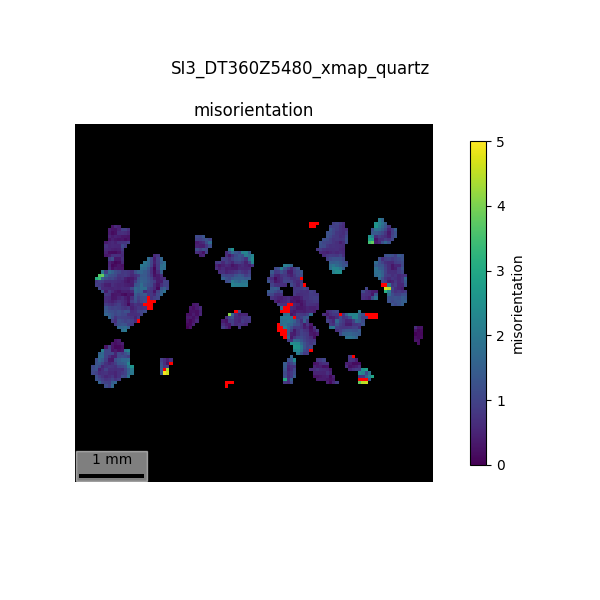

In [31]:
# map grain orientation
xmap2.map_grain_prop('U', pname='quartz')

# reset notindexed pixels to -1 
notindexed = xmap2.phase_id != xmap2.phases.quartz.phase_id
xmap2.misorientation[notindexed] = -1

# make a plot
cmap_o = pl.matplotlib.cm.viridis.copy()
cmap_o.set_extremes(under='k', over='r')

kw = {'cmap':cmap_o, 'vmin':0,'vmax':5}
xmap2.plot('misorientation', autoscale=False, save=False, **kw)